In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
                
        size = self.data_rho.shape[0]
        rho_vec = rho * torch.ones(size)
        
        l1_loss = nn.L1Loss()
        self._rho_loss = l1_loss(self.data_rho, rho_vec)
                
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.943931 32: 0.936157 64: 0.932320
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.456448 32: 0.369704 64: 0.318761
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.316909 32: 0.297055 64: 0.283364
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.281301 32: 0.262220 64: 0.254905
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.241751 32: 0.228989 64: 0.211993
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.202084 32: 0.191485 64: 0.175892
Test set:
16: loss: 0.2117	pho_loss: 0.0000
32: loss: 0.2001	pho_loss: 0.0000
64: loss: 0.1861	pho_loss: 0.0000

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.213955 32: 0.205918 64: 0.189189
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.202968 32: 0.187257 64: 0.177003
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.188016 32: 0.171404 64: 0.162886
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.168878 32: 0.152317 64: 0.143354
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.157869 32: 0.144518 64: 0.134167
Train

Test set:
16: loss: 0.0862	pho_loss: 0.0000
32: loss: 0.0635	pho_loss: 0.0000
64: loss: 0.0506	pho_loss: 0.0000

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.085824 32: 0.061206 64: 0.048368
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.073941 32: 0.051823 64: 0.041936
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.093102 32: 0.069819 64: 0.057909
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.089225 32: 0.063164 64: 0.051624
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.088183 32: 0.065276 64: 0.051497
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.093351 32: 0.065988 64: 0.053574
Test set:
16: loss: 0.0848	pho_loss: 0.0000
32: loss: 0.0597	pho_loss: 0.0000
64: loss: 0.0481	pho_loss: 0.0000

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.087649 32: 0.060890 64: 0.048750
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.085846 32: 0.062783 64: 0.052017
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.085517 32: 0.061128 64: 0.048471
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

Train Epoch: 28 [40000/50000 (80%)]	Losses 16: 0.072366 32: 0.046276 64: 0.033587
Train Epoch: 28 [50000/50000 (100%)]	Losses 16: 0.082181 32: 0.049874 64: 0.037016
Test set:
16: loss: 0.0783	pho_loss: 0.0000
32: loss: 0.0490	pho_loss: 0.0000
64: loss: 0.0353	pho_loss: 0.0000

Train Epoch: 29 [0/50000 (0%)]	Losses 16: 0.072728 32: 0.045468 64: 0.032640
Train Epoch: 29 [10000/50000 (20%)]	Losses 16: 0.086832 32: 0.046993 64: 0.034133
Train Epoch: 29 [20000/50000 (40%)]	Losses 16: 0.085598 32: 0.053615 64: 0.039331
Train Epoch: 29 [30000/50000 (60%)]	Losses 16: 0.083211 32: 0.049385 64: 0.036416
Train Epoch: 29 [40000/50000 (80%)]	Losses 16: 0.086408 32: 0.051824 64: 0.039233
Train Epoch: 29 [50000/50000 (100%)]	Losses 16: 0.076481 32: 0.047359 64: 0.036641
Test set:
16: loss: 0.0771	pho_loss: 0.0000
32: loss: 0.0482	pho_loss: 0.0000
64: loss: 0.0354	pho_loss: 0.0000

Train Epoch: 30 [0/50000 (0%)]	Losses 16: 0.072077 32: 0.044072 64: 0.032181
Train Epoch: 30 [10000/50000 (20%)]	Losses 1

In [9]:
torch.save(models['64'], './model_64_tanh_l1')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [10]:
model = torch.load('./model_64_tanh_l1')

In [11]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[abs(encoded) < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 3,  2,  1,  3,  1,  1,  1,  2,  3,  1,  1,  3,  0,  4,
         1,  0,  1,  3,  1,  3,  1,  1,  2,  0,  0,  2,  0,  1,
         3,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  2,  1,  2,
         1,  1,  1,  1,  1,  2,  3,  0])


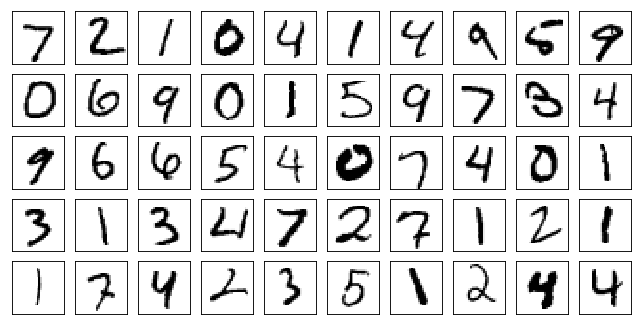

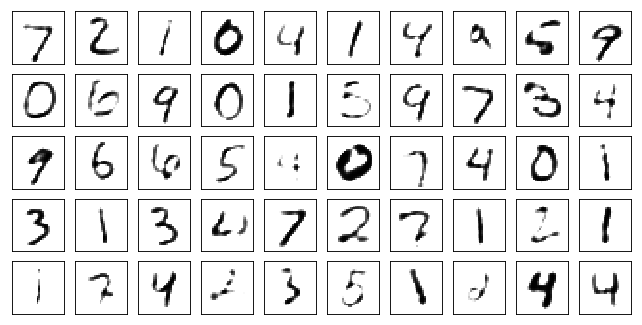

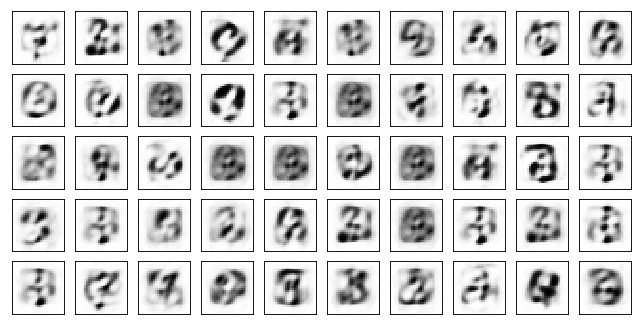

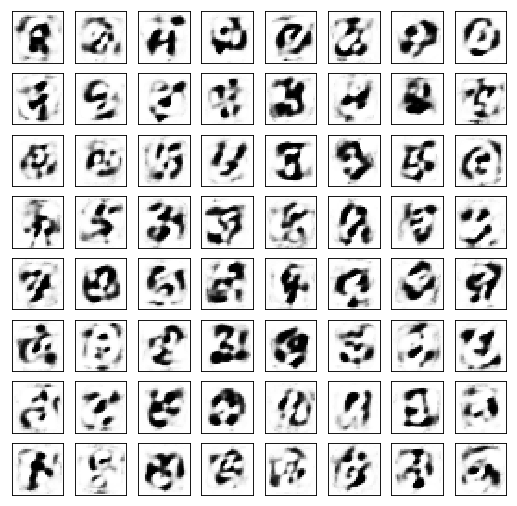

In [12]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))